# Example bioinformatics notebook
### Generation of protein expression sequences and primers

A common practice when trying to express a target protein is to generate truncated versions of the protein sequence to find a shortened version with higher expression and/or stability. This is a standard first step in the protein production at [the SGC](https://www.thesgc.org/), for example.

In this example notebook, we will use [DDR1](https://www.uniprot.org/uniprotkb/Q08345/entry) as an example protein, a receptor tyrosine kinase I have previously [published on](https://www.sciencedirect.com/science/article/pii/S0022283614001983).

We provide 2 inputs, the UniProt ID of our target protein (Q08345) and a text string annotated with the start and end points we would like to use for our truncated sequences.

The notebook will:
- Generate protein sequences using every combination of start and end points
- Generate primers to PCR-amplify DNA sequences encoding those sequences from a synthetic DNA template
- Generate an order form for those primers
- Generate a picklist to supply to an [Echo liquid handler](https://www.mybeckman.uk/landing/ppc/liquid-handlers/acoustic-liquid-handling?utm_source=google&utm_medium=cpc&utm_term=echo+liquid+handler&gad_source=1&gad_campaignid=21016212679&gbraid=0AAAAADsAn-Q4Es5pa32v9jui3bvrCuXa3&gclid=Cj0KCQjw-NfDBhDyARIsAD-ILeDZpjhBYynMtul7uo-crpUG9bHPMi_QFVLMV6QvmZ3-l0LYzOc9DeQaAt4SEALw_wcB) to dispense the primers into a PCR reaction plate.

There will be two output files:
- `primer_order.xlsx`, an Excel file pre-formatted to upload to the [Merck primer order system](https://www.sigmaaldrich.com/GB/en/technical-documents/technical-article/genomics/pcr/standard-dna-synthesis).
- `echo_picklist.csv`, a `.csv` file to progamme the primer dispense steps on an Echo liquid handler.

I have kept the notebook short for simplicity but I have previously extended this and similar workflows to include:
- Analysis of the generated protein sequences (for example with PFAM domain annotations).
- Generation of annotated plasmid files.
- Upload of generated plasmid files to an ELN/LIMS system.
- Support for multiple target proteins cloned into multiple different vectors.


In [ ]:
# Imports
from typing import Final
import requests
from dataclasses import dataclass
from enum import StrEnum
import py3Dmol
import pandas as pd
import matplotlib.pyplot as plt
from Bio.Seq import Seq
from Bio import SeqRecord
from Bio.Data import CodonTable
from Bio.SeqUtils import MeltingTemp as mt
from string import ascii_uppercase
from pathlib import Path

#### Provide the Uniprot ID of your target protein

In [ ]:
TARGET_UNIPROT_ID: Final = "Q08345"

#### Set some more parameters

Set a few parameters we will use later in the notebook.

In [ ]:
# Some parameters for the designed primers:

# the required Tm of the annealing portion of the primers:
PRIMER_TARGET_TM = 60
# BsaI restriction site extensions for the primers:
BSAI_PRIMER_EXTENSIONS = {"fwd": "TATGGTCTCACGAG", "rev": "TATGGTCTCAATGGCTA"}
# When designing primers, we prefer them to end in G or C to reduce mispriming:
PREFERRED_END_NUCLEOTIDES = ["G", "C"]
# minimium primer length:
MIN_PRIMER_LENGTH = 20
# Codon length, in base pairs
CODON_LENGTH = 3

# Base URL for AlphaFoldDB API and headers for requests
ALPHAFOLDDB_BASE_URL = "https://alphafold.ebi.ac.uk/api/prediction"
HEADERS = {
    "Accept": "application/json",
}

# CodonTable for reverse translation
CODON_TABLE = CodonTable.unambiguous_dna_by_id[1]  # Standard table

# Echo transfer volume in nanolitres
PCR_REACTION_VOLUME = 5 # µl
PRIMER_CONCENTRATION = 100 # µM
REQUIRED_PRIMER_CONCENTRATION = 250 # nM
ECHO_TRANSFER_VOLUME_NL = (REQUIRED_PRIMER_CONCENTRATION / 1000) / PRIMER_CONCENTRATION * PCR_REACTION_VOLUME * 1000 # nL

# StrEnum for primer directions
class PrimerDirection(StrEnum):
    fwd = "fwd"
    rev = "rev"


#### Get data on your target protein

First we will retrieve info on the target protein using the provided UniProt ID, retrieved from the [AlphaFoldDB](https://alphafold.ebi.ac.uk/) via their API.

Retrieved data is stored as a dataclass which then generates an example DNA template sequence by reverse translation.

The DNA template sequence generated here is only as an example, for a real experiment you would want to generate codon-optimised DNA for synthesis, which can be a step in this workflow by using (for example) the [GeneArt API](https://assets.thermofisher.com/TFS-Assets/BID/Reference-Materials/geneart-gene-synthesis-api-presentation.pdf) or the [Twist API](https://www.twistbioscience.com/tapi).

To help with choosing sequence truncations to test, we will get the AlphaFold predicted structure and visualise it below.

In [ ]:
def reverse_translate(protein_sequence: str, table: CodonTable) -> str:
    """Basic reverse translation of a protein sequence to a DNA sequence."""
    dna_sequence = ""
    for amino_acid in protein_sequence:
        codons = [
            codon for codon, aa in table.forward_table.items() if aa == amino_acid
        ]
        if codons:
            # Just take the first codon for simplicity
            chosen_codon = codons[0]
            dna_sequence += chosen_codon
        else:
            dna_sequence += "NNN"  # Handle unknown amino acids
    return dna_sequence


@dataclass
class TargetData:
    uniprot_id: str
    uniprot_sequence: str
    alphafold_db_url: str

    @property
    def template_dna_sequence(self) -> str:
        """Returns an example DNA sequence encoding the UniProt sequence."""
        return Seq(
            reverse_translate(protein_sequence=self.uniprot_sequence, table=CODON_TABLE)
        )


def fetch_target_data(uniprot_id: str) -> TargetData:
    """Fetches target data from AlphaFoldDB for a given UniProt ID."""
    response = requests.get(
        f"{ALPHAFOLDDB_BASE_URL}/{uniprot_id}", headers=HEADERS
    )
    if response.status_code != 200:
        raise RuntimeError(
            f"Failed to fetch prediction: {response.status_code} {response.reason}"
        )
    # use the first prediction in the response
    first_prediction = response.json()[0]
    database_info = TargetData(
        uniprot_id=uniprot_id,
        uniprot_sequence=first_prediction["uniprotSequence"],
        alphafold_db_url=first_prediction["pdbUrl"],
    )
    return database_info


target_data = fetch_target_data(uniprot_id=TARGET_UNIPROT_ID)
print(
    f"UniProt sequence for target {TARGET_UNIPROT_ID}:\n{target_data.uniprot_sequence}"
)
r = requests.get(target_data.alphafold_db_url)
pdb_str = r.content.decode("utf-8")
view = py3Dmol.view(width=400, height=300)
view.addModels(pdb_str, "pdb")
view.setStyle({"cartoon": {"color": "spectrum"}})

print(f"AlphaFold structure for target {TARGET_UNIPROT_ID}:")
view.zoomTo()
view.show()

UniProt sequence for target Q08345:
MGPEALSSLLLLLLVASGDADMKGHFDPAKCRYALGMQDRTIPDSDISASSSWSDSTAARHSRLESSDGDGAWCPAGSVFPKEEEYLQVDLQRLHLVALVGTQGRHAGGLGKEFSRSYRLRYSRDGRRWMGWKDRWGQEVISGNEDPEGVVLKDLGPPMVARLVRFYPRADRVMSVCLRVELYGCLWRDGLLSYTAPVGQTMYLSEAVYLNDSTYDGHTVGGLQYGGLGQLADGVVGLDDFRKSQELRVWPGYDYVGWSNHSFSSGYVEMEFEFDRLRAFQAMQVHCNNMHTLGARLPGGVECRFRRGPAMAWEGEPMRHNLGGNLGDPRARAVSVPLGGRVARFLQCRFLFAGPWLLFSEISFISDVVNNSSPALGGTFPPAPWWPPGPPPTNFSSLELEPRGQQPVAKAEGSPTAILIGCLVAIILLLLLIIALMLWRLHWRRLLSKAERRVLEEELTVHLSVPGDTILINNRPGPREPPPYQEPRPRGNPPHSAPCVPNGSALLLSNPAYRLLLATYARPPRGPGPPTPAWAKPTNTQAYSGDYMEPEKPGAPLLPPPPQNSVPHYAEADIVTLQGVTGGNTYAVPALPPGAVGDGPPRVDFPRSRLRFKEKLGEGQFGEVHLCEVDSPQDLVSLDFPLNVRKGHPLLVAVKILRPDATKNARNDFLKEVKIMSRLKDPNIIRLLGVCVQDDPLCMITDYMENGDLNQFLSAHQLEDKAAEGAPGDGQAAQGPTISYPMLLHVAAQIASGMRYLATLNFVHRDLATRNCLVGENFTIKIADFGMSRNLYAGDYYRVQGRAVLPIRWMAWECILMGKFTTASDVWAFGVTLWEVLMLCRAQPFGQLTDEQVIENAGEFFRDQGRQVYLSRPPACPQGLYELMLRCWSRESEQRPPFSQLHRFLAEDALNTV
AlphaFold structure for target Q08345:


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

#### Input domain boundaries

Here we provide all the start and end points we want to use for the truncated versions of the protein. The sequence is annotated with a `>` for start points to use and `<` for end points. Truncated versions of the protein will then be generated that that use every possible combinations of start and end points in the sequence:


In [ ]:
BOUNDARIES = ">MGPEALSSLLLLLLVASGDADMKGHFDPAK>CRYALGMQDRTIPDSDISASSSW>SDSTAARHSRLESSDGDGAWCPAGSVFPKEEEYLQVDLQRLHLVALVGTQGRHAGGLGKEFSRSYRLRYSRDGRRWMGWKDRWGQEVISGNEDPEGVVLKDLGPPMVARLVRFYPRADRVMSVCLRVELYGCLWRD>GL>LSYTAPVGQTMYLSEAVYLNDSTYDGHTVGGLQYGGLGQLADGVVGLDDFRKSQELRVWPGYDYVGWSNHSFSSGYVEMEFEFDRLRAFQAMQVHCNNMHTLGARLPGGVECRFRRGPAMAWEGEPMRHNLGGNLGDPRARAVSVPLGGRVARFLQCRFLFAGPWLLFSEISFISD<VVNNSSPALGGTFPPAPWWPPGPPPTNFSSLELEPRGQQPVAKAEGSPTAILIGCLVAIILLLLLIIALMLWRLHWRRLLSKAERRVLEEELTVHLSVPGDTILINNRPGPREPPPYQEPRPRGNPPHSAPCVPNGSALLLSNPAYRLLLATYARPPRGPGPPTPAWAKPTNTQAYSGDYMEPEKPGAPLLPPPPQNSVPHYAEADIVTLQGVTGGNTYAVPALPPGAVGDGP>PRVDFPRSR>LRFKEKLGEGQFGEVHLCEVDSPQDLVSLDFPLNVRKGHPLLVAVKILRPDATKNARNDFLKEVKIMSRLKDPNIIRLLGVCVQDDPLCMITDYMENGDLNQFLSAHQLEDKAAEGAPGDGQAAQGPTISYPMLLHVAAQIASGMRYLATLNFVHRDLATRNCLVGENFTIKIADFGMSRNLYAGDYYRVQGRAVLPIRWMAWECILMGKFTTASDVWAFGVTLWEVLMLCRAQPFGQ<LTDEQVIENAGEFFRDQGRQVYLSRPPACPQGLYELMLRCWSRESEQRPPFSQLHRFL<AEDALNTV<"

#### Generate the requested protein sequence fragments

In [ ]:
def fragment_protein_sequence(*, boundaries: str) -> list[str]:
    """ Fragment a protein sequence into multiple sequences based on start and end boundaries.
    The boundaries are defined by '>' for start and '<' for end.
    Args:
        boundaries (str): A string containing the protein sequence with '>' indicating start points and '<' indicating end points.
    Returns:
        list[str]: A list of protein sequences generated from the provided boundaries.
    """
    protein_sequences = []
    # split the protein sequence at the 'start' boundaries indicated by ">"
    starts = boundaries.split(">")[1:]
    current_sequence = ""
    # loop through the split protein sequence segments
    for start in reversed(starts):
        # extend the construct by the next start point sequence
        current_sequence = start + current_sequence
        # split this sequence at the end boundaries indicated by "<"
        ends = current_sequence.split("<")[:-1]
        final_sequence = ""
        # loop through the 'end' sequences
        for end in ends:
            # extend the current start sequence to the current 'end' sequence
            final_sequence = final_sequence + end
            # add this generated protein sequence to the list of sequences for this target
            protein_sequences.append(final_sequence)
    return protein_sequences


protein_sequences = fragment_protein_sequence(boundaries=BOUNDARIES)
print(f"Generated protein sequences for target {TARGET_UNIPROT_ID}:")
protein_sequences

Generated protein sequences for target Q08345:


['LRFKEKLGEGQFGEVHLCEVDSPQDLVSLDFPLNVRKGHPLLVAVKILRPDATKNARNDFLKEVKIMSRLKDPNIIRLLGVCVQDDPLCMITDYMENGDLNQFLSAHQLEDKAAEGAPGDGQAAQGPTISYPMLLHVAAQIASGMRYLATLNFVHRDLATRNCLVGENFTIKIADFGMSRNLYAGDYYRVQGRAVLPIRWMAWECILMGKFTTASDVWAFGVTLWEVLMLCRAQPFGQ',
 'LRFKEKLGEGQFGEVHLCEVDSPQDLVSLDFPLNVRKGHPLLVAVKILRPDATKNARNDFLKEVKIMSRLKDPNIIRLLGVCVQDDPLCMITDYMENGDLNQFLSAHQLEDKAAEGAPGDGQAAQGPTISYPMLLHVAAQIASGMRYLATLNFVHRDLATRNCLVGENFTIKIADFGMSRNLYAGDYYRVQGRAVLPIRWMAWECILMGKFTTASDVWAFGVTLWEVLMLCRAQPFGQLTDEQVIENAGEFFRDQGRQVYLSRPPACPQGLYELMLRCWSRESEQRPPFSQLHRFL',
 'LRFKEKLGEGQFGEVHLCEVDSPQDLVSLDFPLNVRKGHPLLVAVKILRPDATKNARNDFLKEVKIMSRLKDPNIIRLLGVCVQDDPLCMITDYMENGDLNQFLSAHQLEDKAAEGAPGDGQAAQGPTISYPMLLHVAAQIASGMRYLATLNFVHRDLATRNCLVGENFTIKIADFGMSRNLYAGDYYRVQGRAVLPIRWMAWECILMGKFTTASDVWAFGVTLWEVLMLCRAQPFGQLTDEQVIENAGEFFRDQGRQVYLSRPPACPQGLYELMLRCWSRESEQRPPFSQLHRFLAEDALNTV',
 'PRVDFPRSRLRFKEKLGEGQFGEVHLCEVDSPQDLVSLDFPLNVRKGHPLLVAVKILRPDATKNARNDFLKEVKIMSRLKDPNIIRLLGVCVQDDPLCMITDYMENGDLNQFLSAHQLEDKAAEGAPGDGQAAQGPTISYPMLLH

#### Visualise the generated sequences compared to the UniProt sequence

Now we will assemble these sequences into a Pandas dataframe with the original UniProt sequence and make a simple visualisation to show the different sequence truncations we have generated and how they relate the to the original UniProt sequence.

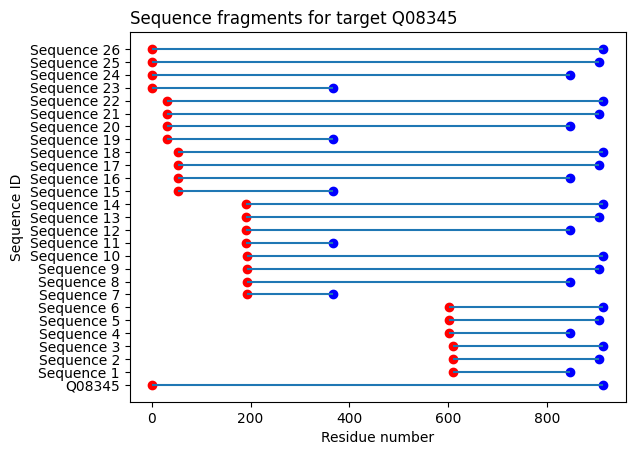

In [ ]:
def assemble_dataframe(*, generated_sequences: list[str], target_data: TargetData) -> pd.DataFrame:
    """Assemble a DataFrame with generated protein sequences and their start and end positions in the UniProt sequence.
    Args:
        generated_sequences (list[str]): A list of generated protein sequences.
        target_data (TargetData): An instance of TargetData containing UniProt ID and sequence.
    Returns:
        pd.DataFrame: A DataFrame containing the sequences, their start and end positions.
    """
    # arrange the protein sequences in a dictionary to be used for plotting
    sequence_info = {
        target_data.uniprot_id: [
            target_data.uniprot_sequence,
            1,
            len(target_data.uniprot_sequence),
        ]
    }

    # find the start and end positions of the generated protein sequences in the UniProt sequence
    # and add them to the sequence_info dictionary
    for i, sequence in enumerate(generated_sequences):
        sequence_info[f"Sequence {i + 1}"] = [
            sequence,
            target_data.uniprot_sequence.find(sequence) + 1,
            target_data.uniprot_sequence.find(sequence) + len(sequence),
        ]
    sequence_df = pd.DataFrame.from_dict(
        sequence_info, orient="index", columns=["Sequence", "Start", "End"]
    )
    return sequence_df

# Assemble the dataframe with the generated sequences and their start and end positions
sequence_df = assemble_dataframe(
    generated_sequences=protein_sequences, target_data=target_data
)
my_range = range(1, len(sequence_df.index) + 1)
# set up a plot to show the sequence fragments compared to the UniProt sequence
plt.hlines(y=my_range, xmin=sequence_df["Start"], xmax=sequence_df["End"])
plt.scatter(sequence_df["Start"], my_range, color="red", alpha=1, label="Start")
plt.scatter(sequence_df["End"], my_range, color="blue", alpha=1, label="End")
# Add title and axis names
plt.yticks(my_range, sequence_df.index)
plt.title(f"Sequence fragments for target {TARGET_UNIPROT_ID}", loc="left")
plt.xlabel("Residue number")
plt.ylabel("Sequence ID")
plt.show()

#### Design primers for these sequences

We want to amplify the DNA sequences that encode these protein sequences by PCR from the DNA template we generated by reverse translation. To do this we need to a forward and reverse primer for each sequence truncation so will generate these here. Primers will be at least 20bp long with a melting temperature (T<sub>m</sub>) of at least 60°C and end in a `G` or `C`.

Primers are then given extensions to make them compatible with our downstream cloning method. In this case they are given `BsaI` restriction sites allowing cloning by [Golden Gate cloning](https://blog.addgene.org/plasmids-101-golden-gate-cloning) into a Golden Gate compatible vector (for example [p324_DG](https://www.addgene.org/234690/)).

We also generate systematic names for the primers. This is a relatively simple implementation but could easily be extended to generate unique names so they can be registered in a database and/or LIMS system:

In [ ]:
def make_primer(
    protein_sequence: str, template: SeqRecord, direction: PrimerDirection
) -> str:
    """Generates a primer sequence for a given protein sequence and template DNA sequence.
    Args:
        protein_sequence (str): The protein sequence for which to design the primer.
        template (SeqRecord): The template DNA sequence from which to design the primer.
        direction (PrimerDirection): The direction of the primer (forward or reverse).
    Returns:
        str: The designed primer sequence.
    """
    # translate the template DNA sequence into a protein sequence
    translation = template.translate()
    # for a fwd primer, find the start point of the construct protein sequence in the translated template sequence
    if direction == PrimerDirection.fwd:
        loc = translation.find(protein_sequence) * CODON_LENGTH
    # for a rev primer, find the end point of the construct protein sequence in the translated template sequence
    if direction == PrimerDirection.rev:
        loc = (translation.find(protein_sequence) + len(protein_sequence)) * CODON_LENGTH
    # start with a primer length of 20bp
    n = MIN_PRIMER_LENGTH
    accepted = False
    # start a while loop
    while not accepted:
        # find the sequence n bases from the start or end for a fwd or rev primer
        if direction == PrimerDirection.fwd:
            primer = template[loc : loc + n]
        if direction == PrimerDirection.rev:
            primer = template[loc - n : loc]
            primer = (primer).reverse_complement()
        # get the tm of that primer sequence
        tm = round(mt.Tm_NN(primer, nn_table=mt.DNA_NN2), 2)
        # if the primer has a Tm above the cutoff specified at the top of the notebook and ends in G or C then accept it
        if tm > PRIMER_TARGET_TM and primer[-1] in PREFERRED_END_NUCLEOTIDES:
            accepted = True
            return str(primer)
        # if not then make the primer 1bp longer and check again
        else:
            n += 1


def generate_96_platemap() -> list[str]:
    """Generate a list of 96-well plate references."""
    wells = []
    for i in range(8):
        for c in range(1, 13):
            r = ascii_uppercase[i]
            wells.append(f"{r}{str(c).zfill(2)}")
    return wells


def generate_primer_names(
    input_df: pd.DataFrame, direction: PrimerDirection
) -> pd.DataFrame:
    """Generate auto-names for the primers based on their direction and order."""
    primers_names = input_df[[f"{direction}_primer"]].copy()
    primers_names.drop_duplicates(inplace=True)
    primers_names.reset_index(inplace=True, drop=True)
    primers_names[f"{direction}_primer_name"] = f"{direction}_primer_" + (
        primers_names.index + 1
    ).astype(str).str.zfill(3)
    return primers_names


# generate the forward and reverse primers for each sequence
for direction in PrimerDirection:
    sequence_df[f"{direction}_primer_annealing"] = sequence_df["Sequence"].apply(
        make_primer, template=target_data.template_dna_sequence, direction=direction
    )
    # extend these primers to include the necessary BsaI extensions
    sequence_df[f"{direction}_primer"] = (
        BSAI_PRIMER_EXTENSIONS[direction] + sequence_df[f"{direction}_primer_annealing"]
    )
    # assign the primers auto-generated names
    primer_names = generate_primer_names(input_df=sequence_df, direction=direction)
    sequence_df = pd.merge(
        sequence_df, primer_names, how="left", on=f"{direction}_primer"
    )

# add 96-well plate well references to the dataframe
wells_96 = generate_96_platemap()
sequence_df["Plate_well"] = wells_96[: len(sequence_df)]
sequence_df.head()

,Sequence,Start,End,fwd_primer_annealing,fwd_primer,fwd_primer_name,rev_primer_annealing,rev_primer,rev_primer_name,Plate_well
0,MGPEALSSLLLLLLVASGDADMKGHFDPAKCRYALGMQDRTIPDSD...,1,913,ATGGGTCCTGAAGCTTTATCTTCTTTATTATTATTATTATTAG,TATGGTCTCACGAGATGGGTCCTGAAGCTTTATCTTCTTTATTATT...,fwd_primer_001,AACAGTATTTAAAGCATCTTCAGCTAAAAAAC,TATGGTCTCAATGGCTAAACAGTATTTAAAGCATCTTCAGCTAAAAAAC,rev_primer_001,A01
1,LRFKEKLGEGQFGEVHLCEVDSPQDLVSLDFPLNVRKGHPLLVAVK...,610,847,TTACGTTTTAAAGAAAAATTAGGTGAAGGTCAATTTG,TATGGTCTCACGAGTTACGTTTTAAAGAAAAATTAGGTGAAGGTCA...,fwd_primer_002,TTGACCAAAAGGTTGAGCACGAC,TATGGTCTCAATGGCTATTGACCAAAAGGTTGAGCACGAC,rev_primer_002,A02
2,LRFKEKLGEGQFGEVHLCEVDSPQDLVSLDFPLNVRKGHPLLVAVK...,610,905,TTACGTTTTAAAGAAAAATTAGGTGAAGGTCAATTTG,TATGGTCTCACGAGTTACGTTTTAAAGAAAAATTAGGTGAAGGTCA...,fwd_primer_002,TAAAAAACGATGTAATTGAGAAAAAGGAGGAC,TATGGTCTCAATGGCTATAAAAAACGATGTAATTGAGAAAAAGGAGGAC,rev_primer_003,A03
3,LRFKEKLGEGQFGEVHLCEVDSPQDLVSLDFPLNVRKGHPLLVAVK...,610,913,TTACGTTTTAAAGAAAAATTAGGTGAAGGTCAATTTG,TATGGTCTCACGAGTTACGTTTTAAAGAAAAATTAGGTGAAGGTCA...,fwd_primer_002,AACAGTATTTAAAGCATCTTCAGCTAAAAAAC,TATGGTCTCAATGGCTAAACAGTATTTAAAGCATCTTCAGCTAAAAAAC,rev_primer_001,A04
4,PRVDFPRSRLRFKEKLGEGQFGEVHLCEVDSPQDLVSLDFPLNVRK...,601,847,CCTCGTGTTGATTTTCCTCGTTCTC,TATGGTCTCACGAGCCTCGTGTTGATTTTCCTCGTTCTC,fwd_primer_003,TTGACCAAAAGGTTGAGCACGAC,TATGGTCTCAATGGCTATTGACCAAAAGGTTGAGCACGAC,rev_primer_002,A05


#### Make an order form for these primers

The primers will need to be ordered so we will generate an excel sheet with all the primer details in the format required by the Merck primer ordering system so no reformatting is required.

Crucially, we are going to use automated liquid handling to set up our experiment which means we only have to order each primer once and primers can be delivered normalised in buffer in a 384-well plate which means there will be minimal reformatting between recieving the plate and running the experiment. I wish I could say no reformatting but Merck do not deliver primers in Echo-qualified source plates and we are going to use an Echo liquid handler so we will at least have to transfer some to the correct plate type.

In [ ]:
def generate_384_platemap() -> list[str]:
    """Generate a list of 384-well plate references."""
    wells = []
    for i in range(16):
        for c in range(1, 25):
            r = ascii_uppercase[i]
            wells.append(f"{r}{str(c).zfill(2)}")
    return wells


def make_primer_plate(input_df: pd.DataFrame) -> pd.DataFrame:
    """Create a primer plate dataframe for ordering primers."""
    # generate a 384-well plate map
    wells_384 = generate_384_platemap()
    # create a new dataframe with the 384-well plate well references
    primer_plate = pd.DataFrame(wells_384, columns=["Plate well"])
    primer_plate["Row"] = primer_plate["Plate well"].str[0]
    primer_plate["Column"] = primer_plate["Plate well"].str[1:].astype(int)
    primer_plate.sort_values(by=["Column", "Row"], inplace=True, ascending=True)

    # get the primers from our input dataframe
    primer_sets = []
    for direction in PrimerDirection:
        # get all the fwd primer names and sequences, rename to match the column headers needed by Merck
        primer_set = input_df[
            [f"{direction}_primer_name", f"{direction}_primer"]
        ].copy()
        primer_set.rename(
            {
                f"{direction}_primer_name": "Name",
                f"{direction}_primer": "Sequence (5' - 3')",
            },
            axis=1,
            inplace=True,
        )
        # add the dataframe to the primer sets list
        primer_sets.append(primer_set)
    # combine the two sets of primers into one dataframe of all the fwd + rev primers with sequences
    all_primers = pd.concat(primer_sets)
    # remove the duplicates so it's just a list of unique primers
    unique_primers = all_primers.drop_duplicates(subset="Sequence (5' - 3')").copy()
    unique_primers.reset_index(inplace=True, drop=True)

    # concat to add the unique primers onto the primer_plate dataframe
    primer_plate = pd.concat(
        [primer_plate, unique_primers[["Name", "Sequence (5' - 3')"]]], axis=1
    ).reindex(primer_plate.index)
    # make 3' mod and 5' columns to match the format needed by Merck
    primer_plate["5' Mod"] = ""
    primer_plate["3' Mod"] = ""
    # remove unneeded columns and order the remaining ones to fit the format
    primer_plate = primer_plate[
        [
            "Plate well",
            "Row",
            "Column",
            "Name",
            "5' Mod",
            "Sequence (5' - 3')",
            "3' Mod",
        ]
    ]
    return primer_plate


primer_plate = make_primer_plate(input_df=sequence_df)

# Check whether the output path exists and create it if not
output_dir = Path("./output")
output_dir.mkdir(exist_ok=True)

primer_order_path = output_dir / "primer_order.xlsx"
print(f"Writing primer order form to {primer_order_path}")
primer_plate[
    ["Row", "Column", "Name", "5' Mod", "Sequence (5' - 3')", "3' Mod"]
].to_excel(primer_order_path, index=False, startrow=2)

### Make Echo input file

We are going to set up our PCR reactions in a 96-well plate by dispensing our primers into the required wells using an Echo liquid handler.

Transfer volume is 12.5nL assuming a 5µl reaction size and 100µM primer concentrations to give a final concentration of 250nM each primer in each reaction.

For simplicity we will assume the plate already has PCR master mix and template in the wells, but this logic could readily be extended to dispense template as well if we have a PCR plate with more than one target/template in it.


In [ ]:
def make_echo_input_file(input_df: pd.DataFrame) -> pd.DataFrame:
    """Create an Echo input file for transferring primers to a PCR plate."""
    # get all the sequences and required primers
    primer_sets = []
    for direction in PrimerDirection:
        # get the required primer for each sequence
        primer_set = input_df[["Plate_well", f"{direction}_primer"]].copy()
        # rename the columns to match the Echo input file format
        primer_set.rename(
            {"Plate_well": "Destination Well", f"{direction}_primer": "Primer"},
            axis=1,
            inplace=True,
        )
        # add the dataframe to the primer sets list
        primer_sets.append(primer_set)
    # combine the two sets of primers into one dataframe of all the fwd + rev primers with sequences
    echo_df = pd.concat(primer_sets, ignore_index=True)
    # merge in the primer plate dataframe to get the source plate locations for the primers
    echo_df = pd.merge(
        echo_df,
        primer_plate,
        how="left",
        left_on="Primer",
        right_on="Sequence (5' - 3')",
    )
    # make source plate name "primer plate", assign primer plate barcode and transfer volume
    echo_df["Source Plate Name"] = "Primer plate"
    echo_df["Source Plate Barcode"] = f"{TARGET_UNIPROT_ID}_primer_plate"
    echo_df["Transfer Volume"] = ECHO_TRANSFER_VOLUME_NL
    # set the source plate type to 384LDV_AQ_B2, which is a Beckman low dead volume 384-well plate
    echo_df["Source Plate Type"] = "384LDV_AQ_B2"
    echo_df["Destination Plate Barcode"] = f"{TARGET_UNIPROT_ID}_PCR_plate"
    echo_df["Destination Plate Name"] = "PCR plate"
    echo_df.rename(
        {"Name": "Sample Name", "Plate well": "Source Well"}, axis=1, inplace=True
    )
    echo_df = echo_df[
        [
            "Source Plate Barcode",
            "Source Plate Name",
            "Source Plate Type",
            "Source Well",
            "Destination Plate Barcode",
            "Destination Plate Name",
            "Destination Well",
            "Transfer Volume",
            "Sample Name",
        ]
    ]
    return echo_df


echo_input_df = make_echo_input_file(input_df=sequence_df)

echo_picklist_path = output_dir / "echo_picklist.csv"
print(f"Writing echo picklist file to {echo_picklist_path}")
echo_input_df.to_csv(echo_picklist_path, index=False)
echo_input_df.head()

Writing echo picklist file to output/echo_picklist.csv


,Source Plate Barcode,Source Plate Name,Source Plate Type,Source Well,Destination Plate Barcode,Destination Plate Name,Destination Well,Transfer Volume,Sample Name
0,Q08345_primer_plate,Primer plate,384LDV_AQ_B2,A01,Q08345_PCR_plate,PCR plate,A01,6.5,fwd_primer_001
1,Q08345_primer_plate,Primer plate,384LDV_AQ_B2,A02,Q08345_PCR_plate,PCR plate,A02,6.5,fwd_primer_002
2,Q08345_primer_plate,Primer plate,384LDV_AQ_B2,A02,Q08345_PCR_plate,PCR plate,A03,6.5,fwd_primer_002
3,Q08345_primer_plate,Primer plate,384LDV_AQ_B2,A02,Q08345_PCR_plate,PCR plate,A04,6.5,fwd_primer_002
4,Q08345_primer_plate,Primer plate,384LDV_AQ_B2,A03,Q08345_PCR_plate,PCR plate,A05,6.5,fwd_primer_003
